<a href="https://colab.research.google.com/github/swilsonmfc/pandas/blob/main/12_Lesson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 12 - Performance

# Install

In [1]:
!pip install pycaret
!pip install shap

# Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.datasets import load_digits
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from pycaret.classification import *
from pycaret.datasets import get_data

In [3]:
pd.set_option("display.max_rows", 100)

# Performance

## Timing Commands
* %time = time spent in next command
* %%time = time spent in cell

In [4]:
%time
MAX = 1_000_000
for x in range(MAX):
  x ** 2

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.63 µs


In [5]:
%%time
MAX = 1_000_000
for x in range(MAX):
  x ** 2

CPU times: user 336 ms, sys: 2.24 ms, total: 338 ms
Wall time: 338 ms


In [6]:
%%timeit -n2 -r3
MAX = 1_000_000
for x in range(MAX):
  x ** 2

2 loops, best of 3: 272 ms per loop


## Vectorized Operations

In [7]:
MAX = 1_000_000
X = [x for x in range(MAX)]
X_df = pd.DataFrame(X, columns=['X'])
X_df

,X
0,0
1,1
2,2
3,3
4,4
...,...
999995,999995
999996,999996
999997,999997
999998,999998


In [10]:
%%timeit -n1 -r1
def divisible_by_three(value):
  if value % 3 == 0:
    return 1
  return 0

# Very slow - let's do 1000 rows 
for idx, row in X_df[0:1000].iterrows():
  X_df.loc[idx]['X_3'] = divisible_by_three(row['X'])

# 1 second / 1000 rows == 16.6 minutes

1 loop, best of 1: 943 ms per loop


In [11]:
%%timeit
def divisible_by_three(row):
  if row['X'] % 3 == 0:
    return 1
  return 0

X_df['X_3'] = X_df.apply(divisible_by_three, axis=1)

1 loop, best of 5: 8.34 s per loop


In [12]:
%%timeit 
def divisible_by_three(value):
  if value % 3 == 0:
    return 1
  return 0

X_df['X_3'] = X_df.X.apply(divisible_by_three)

1 loop, best of 5: 411 ms per loop


In [13]:
%%timeit 
X_df['X_3'] = np.where(X_df.X % 3 == 0, 1, 0)

10 loops, best of 5: 20.5 ms per loop


In [20]:
%%timeit
X_df['X_3'] = np.where(np.mod(X_df.X, 3) == 0, 1, 0)

10 loops, best of 5: 20.3 ms per loop


In [14]:
%%timeit
X_df['X_3'] = X_df.X % 3 == 0
X_df['X_3'] = X_df.X_3.astype(int)

100 loops, best of 5: 19.1 ms per loop


## Chunking
* An approach to handling a dataset that's larger than you can read

In [ ]:
X, y = make_blobs(n_samples=10_000_000)
np.savetxt('out.csv', X, delimiter=',')

In [ ]:
!ls -al

total 496636
drwxr-xr-x 1 root root      4096 Oct 27 19:12 .
drwxr-xr-x 1 root root      4096 Oct 27 17:04 ..
drwxr-xr-x 4 root root      4096 Oct  8 13:44 .config
-rw-r--r-- 1 root root 508537853 Oct 27 19:43 out.csv
drwxr-xr-x 1 root root      4096 Oct  8 13:45 sample_data


In [ ]:
%%timeit
df = pd.read_csv('out.csv', names=['col1', 'col2'])
df['product'] = df.col1 * df.col2

1 loop, best of 5: 4.68 s per loop


In [ ]:
%%timeit
chunks = pd.read_csv('out.csv', names=['col1', 'col2'], chunksize=1_000_000)
for chunk in chunks:
  chunk['product'] = chunk.col1 * chunk.col2

1 loop, best of 5: 4.89 s per loop


## Sampling

In [ ]:
df = pd.read_csv('out.csv', names=['col1', 'col2'])
df.describe()

,col1,col2
count,1.000000e+07,1.000000e+07
mean,1.816111e+00,7.723688e-01
std,5.743298e+00,1.943032e+00
min,-9.570164e+00,-6.366940e+00
25%,-3.764574e+00,-7.256705e-01
50%,6.269316e-01,3.035808e-01
75%,8.585732e+00,2.450050e+00
max,1.451493e+01,8.329833e+00


In [ ]:
ROWS = 1000
df = pd.read_csv('out.csv', 
                 names=['col1', 'col2'], 
                 skiprows=lambda i: i % ROWS != 0)
df.describe()

,col1,col2
count,10000.000000,10000.000000
mean,1.846935,0.771637
std,5.732448,1.936454
min,-7.846704,-4.392332
25%,-3.716594,-0.709012
50%,0.683977,0.300057
75%,8.572766,2.441227
max,12.884963,6.428132


## Data Types

In [111]:
df = get_data('house')
df;

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [112]:
df.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1         int64
BsmtFinType2      object
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
Heating           object


In [113]:
# Nominal Memory
nominal = df.memory_usage().sum()
nominal

946208

In [114]:
df.memory_usage()

Index              128
Id               11680
MSSubClass       11680
MSZoning         11680
LotFrontage      11680
LotArea          11680
Street           11680
Alley            11680
LotShape         11680
LandContour      11680
Utilities        11680
LotConfig        11680
LandSlope        11680
Neighborhood     11680
Condition1       11680
Condition2       11680
BldgType         11680
HouseStyle       11680
OverallQual      11680
OverallCond      11680
YearBuilt        11680
YearRemodAdd     11680
RoofStyle        11680
RoofMatl         11680
Exterior1st      11680
Exterior2nd      11680
MasVnrType       11680
MasVnrArea       11680
ExterQual        11680
ExterCond        11680
Foundation       11680
BsmtQual         11680
BsmtCond         11680
BsmtExposure     11680
BsmtFinType1     11680
BsmtFinSF1       11680
BsmtFinType2     11680
BsmtFinSF2       11680
BsmtUnfSF        11680
TotalBsmtSF      11680
Heating          11680
HeatingQC        11680
CentralAir       11680
Electrical 

In [115]:
# Inspect deeper
deep = df.memory_usage(deep=True).sum()
deep

4068286

In [116]:
df.memory_usage(deep=True)

Index              128
Id               11680
MSSubClass       11680
MSZoning         86190
LotFrontage      11680
LotArea          11680
Street           89060
Alley            49359
LotShape         87600
LandContour      87600
Utilities        91980
LotConfig        91921
LandSlope        87600
Neighborhood     92702
Condition1       89237
Condition2       89070
BldgType         89497
HouseStyle       91850
OverallQual      11680
OverallCond      11680
YearBuilt        11680
YearRemodAdd     11680
RoofStyle        89969
RoofMatl         93435
Exterior1st      93410
Exterior2nd      93401
MasVnrType       90321
MasVnrArea       11680
ExterQual        86140
ExterCond        86140
Foundation       91273
BsmtQual         85141
BsmtCond         85141
BsmtExposure     85114
BsmtFinType1     86564
BsmtFinSF1       11680
BsmtFinType2     86536
BsmtFinSF2       11680
BsmtUnfSF        11680
TotalBsmtSF      11680
Heating          89061
HeatingQC        86140
CentralAir       84680
Electrical 

In [117]:
# Convert Object Columns to Categories
start = df.memory_usage(deep=True).sum()
for col in df.select_dtypes('O'):
  print(col)
  df[col] = df[col].astype('category')
print(start)
df.memory_usage(deep=True).sum()

MSZoning
Street
Alley
LotShape
LandContour
Utilities
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
ExterQual
ExterCond
Foundation
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
Heating
HeatingQC
CentralAir
Electrical
KitchenQual
Functional
FireplaceQu
GarageType
GarageFinish
GarageQual
GarageCond
PavedDrive
PoolQC
Fence
MiscFeature
SaleType
SaleCondition
4068286


530869

In [118]:
df.memory_usage(deep=True)

Index              128
Id               11680
MSSubClass       11680
MSZoning          1920
LotFrontage      11680
LotArea          11680
Street            1662
Alley             1662
LotShape          1860
LandContour       1860
Utilities         1666
LotConfig         1930
LandSlope         1720
Neighborhood      3691
Condition1        2332
Condition2        2271
BldgType          1932
HouseStyle        2282
OverallQual      11680
OverallCond      11680
YearBuilt        11680
YearRemodAdd     11680
RoofStyle         1992
RoofMatl          2287
Exterior1st       3056
Exterior2nd       3118
MasVnrType        1870
MasVnrArea       11680
ExterQual         1856
ExterCond         1915
Foundation        1992
BsmtQual          1856
BsmtCond          1856
BsmtExposure      1856
BsmtFinType1      1980
BsmtFinSF1       11680
BsmtFinType2      1980
BsmtFinSF2       11680
BsmtUnfSF        11680
TotalBsmtSF      11680
Heating           1987
HeatingQC         1915
CentralAir        1656
Electrical 

In [119]:
# Int 64 to Smaller Space
df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [120]:
start = df.memory_usage(deep=True).sum()
for col in df.select_dtypes('int64'):
  print(col)
  df[col] = df[col].astype('int32')
print(start)
final = df.memory_usage(deep=True).sum()
final

Id
MSSubClass
LotArea
OverallQual
OverallCond
YearBuilt
YearRemodAdd
BsmtFinSF1
BsmtFinSF2
BsmtUnfSF
TotalBsmtSF
1stFlrSF
2ndFlrSF
LowQualFinSF
GrLivArea
BsmtFullBath
BsmtHalfBath
FullBath
HalfBath
BedroomAbvGr
KitchenAbvGr
TotRmsAbvGrd
Fireplaces
GarageCars
GarageArea
WoodDeckSF
OpenPorchSF
EnclosedPorch
3SsnPorch
ScreenPorch
PoolArea
MiscVal
MoSold
YrSold
SalePrice
530869


326469

In [121]:
# Compare
print(f'{deep:,}')
print(f'{final:,}')

4,068,286
326,469


## Parquet

In [76]:
X, y = make_blobs(n_samples=1_000_000, n_features=20)
df = pd.DataFrame(X)
df.columns = [f'col_{x}' for x in range(len(df.columns))]
df.to_csv('wide.csv')
df.to_parquet('wide.parquet')

In [77]:
!ls -al

total 534700
drwxr-xr-x 1 root root      4096 Oct 29 15:54 .
drwxr-xr-x 1 root root      4096 Oct 29 14:39 ..
drwxr-xr-x 4 root root      4096 Oct 26 13:33 .config
-rw-r--r-- 1 root root    144702 Oct 29 15:18 logs.log
-rw-r--r-- 1 root root     11528 Oct 29 15:18 player_classifier.pkl
drwxr-xr-x 1 root root      4096 Oct 26 13:34 sample_data
-rw-r--r-- 1 root root 381746054 Oct 29 16:02 wide.csv
-rw-r--r-- 1 root root 165609435 Oct 29 16:02 wide.parquet


In [78]:
# Timing reading data

In [79]:
%%timeit
df = pd.read_csv('wide.csv')

1 loop, best of 5: 4.69 s per loop


In [80]:
%%timeit
df = pd.read_parquet('wide.parquet')

1 loop, best of 5: 202 ms per loop


In [81]:
# Timing read one column

In [82]:
%%timeit
df = pd.read_csv('wide.csv', usecols=['col_4'])

1 loop, best of 5: 2.11 s per loop


In [83]:
%%timeit
df = pd.read_parquet('wide.parquet', columns=['col_4'])

100 loops, best of 5: 14.5 ms per loop


# Principal Component Analysis PCA
* How can we reduce the dimensionality of the data while preserving the information in the data?
* PCA transforms a large number of variables into a smaller set of variables that explains the maximum amount of variance in the original data


## Data

In [42]:
X, y = load_digits(return_X_y=True)

In [43]:
X[0]

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

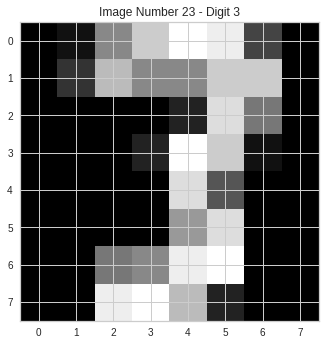

In [44]:
DISPLAY = 23
plt.imshow(np.reshape(X[DISPLAY], (8, 8)), cmap='gray')
plt.title(f'Image Number {DISPLAY} - Digit {y[DISPLAY]}');

In [45]:
images_df = pd.DataFrame(X)
images_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,13.0,15.0,10.0,15.0,5.0,0.0,0.0,3.0,15.0,2.0,0.0,11.0,8.0,0.0,0.0,4.0,12.0,0.0,0.0,8.0,8.0,0.0,0.0,5.0,8.0,0.0,0.0,9.0,8.0,0.0,0.0,4.0,11.0,0.0,1.0,12.0,7.0,0.0,0.0,2.0,14.0,5.0,10.0,12.0,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,0.0,11.0,16.0,9.0,0.0,0.0,0.0,0.0,3.0,15.0,16.0,6.0,0.0,0.0,0.0,7.0,15.0,16.0,16.0,2.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,3.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,6.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,6.0,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,3.0,16.0,15.0,14.0,0.0,0.0,0.0,0.0,8.0,13.0,8.0,16.0,0.0,0.0,0.0,0.0,1.0,6.0,15.0,11.0,0.0,0.0,0.0,1.0,8.0,13.0,15.0,1.0,0.0,0.0,0.0,9.0,16.0,16.0,5.0,0.0,0.0,0.0,0.0,3.0,13.0,16.0,16.0,11.0,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,13.0,6.0,15.0,4.0,0.0,0.0,0.0,2.0,1.0,13.0,13.0,0.0,0.0,0.0,0.0,0.0,2.0,15.0,11.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,12.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,10.0,8.0,0.0,0.0,0.0,8.0,4.0,5.0,14.0,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,8.0,0.0,0.0,0.0,0.0,0.0,1.0,13.0,6.0,2.0,2.0,0.0,0.0,0.0,7.0,15.0,0.0,9.0,8.0,0.0,0.0,5.0,16.0,10.0,0.0,16.0,6.0,0.0,0.0,4.0,15.0,16.0,13.0,16.0,1.0,0.0,0.0,0.0,0.0,3.0,15.0,10.0,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1792,0.0,0.0,4.0,10.0,13.0,6.0,0.0,0.0,0.0,1.0,16.0,14.0,12.0,16.0,3.0,0.0,0.0,4.0,16.0,6.0,3.0,16.0,4.0,0.0,0.0,0.0,12.0,16.0,16.0,16.0,5.0,0.0,0.0,0.0,0.0,4.0,4.0,16.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,5.0,0.0,0.0,0.0,5.0,7.0,7.0,16.0,4.0,0.0,0.0,0.0,2.0,14.0,15.0,9.0,0.0,0.0
1793,0.0,0.0,6.0,16.0,13.0,11.0,1.0,0.0,0.0,0.0,16.0,15.0,12.0,16.0,1.0,0.0,0.0,3.0,16.0,7.0,0.0,13.0,6.0,0.0,0.0,4.0,16.0,0.0,0.0,10.0,8.0,0.0,0.0,8.0,16.0,0.0,0.0,14.0,6.0,0.0,0.0,5.0,16.0,7.0,9.0,16.0,5.0,0.0,0.0,1.0,15.0,16.0,16.0,16.0,1.0,0.0,0.0,0.0,6.0,16.0,14.0,6.0,0.0,0.0
1794,0.0,0.0,1.0,11.0,15.0,1.0,0.0,0.0,0.0,0.0,13.0,16.0,8.0,2.0,1.0,0.0,0.0,0.0,16.0,15.0,10.0,16.0,5.0,0.0,0.0,0.0,8.0,16.0,16.0,7.0,0.0,0.0,0.0,0.0,9.0,16.0,16.0,4.0,0.0,0.0,0.0,0.0,16.0,14.0,16.0,15.0,0.0,0.0,0.0,0.0,15.0,15.0,15.0,16.0,0.0,0.0,0.0,0.0,2.0,9.0,13.0,6.0,0.0,0.0
1795,0.0,0.0,2.0,10.0,7.0,0.0,0.0,0.0,0.0,0.0,14.0,16.0,16.0,15.0,1.0,0.0,0.0,4.0,16.0,7.0,3.0,16.0,7.0,0.0,0.0,5.0,16.0,10.0,7.0,16.0,4.0,0.0,0.0,0.0,5.0,14.0,14.0,16.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,2.0,0.0,0.0,0.0,4.0,7.0,7.0,16.0,2.0,0.0,0.0,0.0,5.0,12.0,16.0,12.0,0.0,0.0


## Intuition
* Generally, we want to scale data before running PCA

In [46]:
pca = PCA(n_components=10)
pca.fit(images_df)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

## Variance Explained

In [47]:
ratios = pca.explained_variance_ratio_
ratios

array([0.14890594, 0.13618771, 0.11794594, 0.08409979, 0.0578241 ,
       0.04916884, 0.04315983, 0.03661368, 0.03353237, 0.030788  ])

In [48]:
sum(ratios)

0.7382261803911485

<BarContainer object of 10 artists>

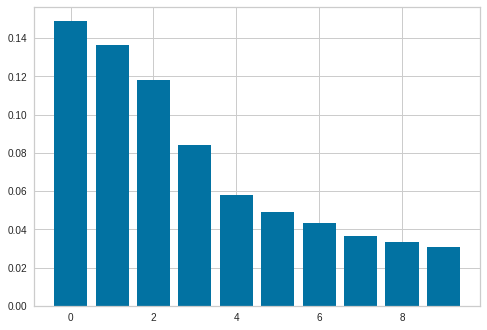

In [49]:
plt.bar(x=[x for x in range(len(ratios))], height=ratios)

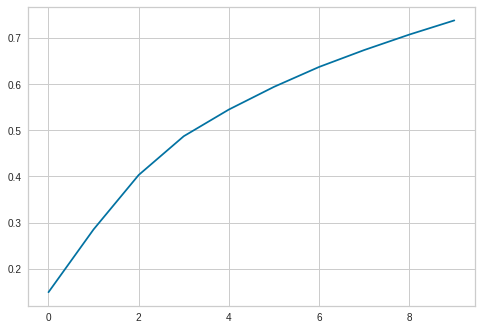

In [50]:
plt.plot(ratios.cumsum())

In [51]:
X_pca = pca.transform(images_df)
images_pca_df = pd.DataFrame(X_pca)
images_pca_df

,0,1,2,3,4,5,6,7,8,9
0,-1.259464,21.274891,-9.463050,13.014351,-7.127953,-7.438322,3.251551,2.552014,-0.580579,3.625706
1,7.957611,-20.768705,4.439502,-14.893791,5.896146,-6.486759,2.126817,-4.615053,3.586551,-1.075578
2,6.991920,-9.955992,2.958556,-12.288357,-18.126786,-4.509930,1.841032,-16.413418,0.722315,4.255229
3,-15.906103,3.332472,9.824378,-12.275647,6.965905,1.092572,-1.043435,10.972258,-3.256111,6.500976
4,23.306877,4.269084,-5.675109,-13.851058,-0.355258,-2.849752,-0.722007,13.039822,-3.831914,13.417867
...,...,...,...,...,...,...,...,...,...,...
1792,-14.606623,13.344139,-13.439036,-6.502630,3.789258,-2.724565,-4.434864,-3.916256,7.325863,-8.446422
1793,6.464570,20.567290,-9.155121,12.553879,-9.016786,-13.710041,3.832996,-3.756987,-7.196346,-5.242539
1794,10.801283,-6.960247,5.599557,-7.227634,-3.459487,-12.374453,-4.490233,-7.416120,-3.961263,-13.065081
1795,-4.872096,12.423962,-10.170858,-6.668613,3.570283,-0.000206,-2.997911,-4.358365,3.945672,-13.143594


## Comparing Performance

In [52]:
# Logistic Regression Classifier (Uses all 64 Features)
lr_all = LogisticRegression()
lr_images_df = images_df.copy()
scaler = StandardScaler()
lr_images_df = scaler.fit_transform(lr_images_df)
X_train, X_test, y_train, y_test = train_test_split(lr_images_df, y, random_state=1011)
lr_all.fit(X_train, y_train)
pred = lr_all.predict(X_test)
print(f'Accuracy : {accuracy_score(y_test, pred) * 100.:.2f}%')

Accuracy : 96.89%


In [53]:
# Logistic Regression Classigier (Uses 10 PCA Transformed Features)
lr_10 = LogisticRegression()
lr_images_pca_df = images_pca_df.copy()
scaler = StandardScaler()
lr_images_pca_df = scaler.fit_transform(lr_images_pca_df)
X_train, X_test, y_train, y_test = train_test_split(lr_images_pca_df, y, random_state=1011)
lr_all.fit(X_train, y_train)
pred = lr_all.predict(X_test)
print(f'Accuracy : {accuracy_score(y_test, pred)* 100.:.2f}%')

Accuracy : 93.56%


## Plotting in Low Dimension

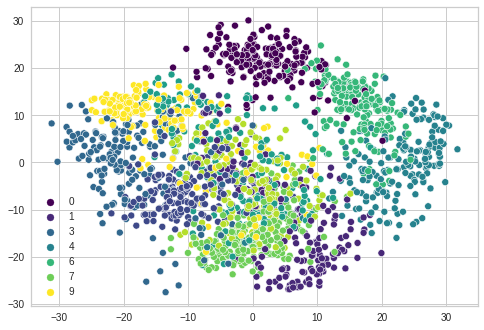

In [62]:
pca2 = PCA(n_components=2)
pca2_data = pca2.fit_transform(X)
sns.scatterplot(pca2_data[:, 0], pca2_data[:, 1], hue=y, palette='viridis');

# PyCaret

## Data
* Load data from pycaret dataset on NBA
* Data involves predicting if the player will be in the league after 5 seasons given their rookie year stats

In [23]:
nba = get_data('nba')
nba

,Name,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,Brandon Ingram,36,27.4,7.4,2.6,7.6,34.7,0.5,2.1,25.0,1.6,2.3,69.9,0.7,3.4,4.1,1.9,0.4,0.4,1.3,0
1,Andrew Harrison,35,26.9,7.2,2.0,6.7,29.6,0.7,2.8,23.5,2.6,3.4,76.5,0.5,2.0,2.4,3.7,1.1,0.5,1.6,0
2,JaKarr Sampson,74,15.3,5.2,2.0,4.7,42.2,0.4,1.7,24.4,0.9,1.3,67.0,0.5,1.7,2.2,1.0,0.5,0.3,1.0,0
3,Malik Sealy,58,11.6,5.7,2.3,5.5,42.6,0.1,0.5,22.6,0.9,1.3,68.9,1.0,0.9,1.9,0.8,0.6,0.1,1.0,1
4,Matt Geiger,48,11.5,4.5,1.6,3.0,52.4,0.0,0.1,0.0,1.3,1.9,67.4,1.0,1.5,2.5,0.3,0.3,0.4,0.8,1


,Name,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,Brandon Ingram,36,27.4,7.4,2.6,7.6,34.7,0.5,2.1,25.0,1.6,2.3,69.9,0.7,3.4,4.1,1.9,0.4,0.4,1.3,0
1,Andrew Harrison,35,26.9,7.2,2.0,6.7,29.6,0.7,2.8,23.5,2.6,3.4,76.5,0.5,2.0,2.4,3.7,1.1,0.5,1.6,0
2,JaKarr Sampson,74,15.3,5.2,2.0,4.7,42.2,0.4,1.7,24.4,0.9,1.3,67.0,0.5,1.7,2.2,1.0,0.5,0.3,1.0,0
3,Malik Sealy,58,11.6,5.7,2.3,5.5,42.6,0.1,0.5,22.6,0.9,1.3,68.9,1.0,0.9,1.9,0.8,0.6,0.1,1.0,1
4,Matt Geiger,48,11.5,4.5,1.6,3.0,52.4,0.0,0.1,0.0,1.3,1.9,67.4,1.0,1.5,2.5,0.3,0.3,0.4,0.8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1335,Chris Smith,80,15.8,4.3,1.6,3.6,43.3,0.0,0.2,14.3,1.2,1.5,79.2,0.4,0.8,1.2,2.5,0.6,0.2,0.8,0
1336,Brent Price,68,12.6,3.9,1.5,4.1,35.8,0.1,0.7,16.7,0.8,1.0,79.4,0.4,1.1,1.5,2.3,0.8,0.0,1.3,1
1337,Marlon Maxey,43,12.1,5.4,2.2,3.9,55.0,0.0,0.0,0.0,1.0,1.6,64.3,1.5,2.3,3.8,0.3,0.3,0.4,0.9,0
1338,Litterial Green,52,12.0,4.5,1.7,3.8,43.9,0.0,0.2,10.0,1.2,1.8,62.5,0.2,0.4,0.7,2.2,0.4,0.1,0.8,1


## Preprocess

In [24]:
clf = setup(nba, target='TARGET_5Yrs', ignore_features=['Name'])

,Description,Value
0,session_id,463
1,Target,TARGET_5Yrs
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(1340, 21)"
5,Missing Values,True
6,Numeric Features,19
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


## Classifier

In [25]:
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7193,0.7658,0.8256,0.7476,0.7841,0.3853,0.3905,0.670
ridge,Ridge Classifier,0.7129,0.0000,0.8273,0.7397,0.7807,0.3685,0.3743,0.017
et,Extra Trees Classifier,0.7119,0.7262,0.7929,0.7557,0.7724,0.3789,0.3822,0.516
lda,Linear Discriminant Analysis,0.7033,0.7658,0.8170,0.7340,0.7728,0.3485,0.3537,0.021
rf,Random Forest Classifier,0.6873,0.7191,0.7652,0.7399,0.7507,0.3300,0.3328,0.604
ada,Ada Boost Classifier,0.6873,0.7193,0.7686,0.7384,0.7519,0.3288,0.3314,0.143
lightgbm,Light Gradient Boosting Machine,0.6809,0.7069,0.7669,0.7324,0.7484,0.3123,0.3140,0.140
knn,K Neighbors Classifier,0.6777,0.7099,0.7704,0.7302,0.7481,0.3006,0.3031,0.120
gbc,Gradient Boosting Classifier,0.6713,0.7099,0.7704,0.7203,0.7434,0.2867,0.2893,0.275
qda,Quadratic Discriminant Analysis,0.6563,0.7463,0.5821,0.8106,0.6753,0.3306,0.3529,0.022


## Create Model

In [26]:
lr = create_model('lr')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6915,0.7792,0.8103,0.7231,0.7642,0.3222,0.3266
1,0.7021,0.7447,0.8621,0.7143,0.7813,0.3272,0.3417
2,0.6596,0.7155,0.7414,0.7167,0.7288,0.2720,0.2723
3,0.7340,0.7754,0.8793,0.7391,0.8031,0.4026,0.4173
4,0.7553,0.7826,0.8448,0.7778,0.8099,0.4683,0.4714
5,0.7340,0.7921,0.8103,0.7705,0.7899,0.4282,0.4292
6,0.7447,0.7672,0.8103,0.7833,0.7966,0.4540,0.4545
7,0.7312,0.7773,0.8421,0.7500,0.7934,0.4124,0.4181
8,0.6989,0.7345,0.8276,0.7273,0.7742,0.3282,0.3344
9,0.7419,0.7897,0.8276,0.7742,0.8000,0.4375,0.4394


## Fine Tune

In [27]:
lr_tuned = tune_model(lr)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7021,0.7802,0.8276,0.7273,0.7742,0.3420,0.3482
1,0.7021,0.7466,0.8621,0.7143,0.7813,0.3272,0.3417
2,0.6809,0.7179,0.7931,0.7188,0.7541,0.3027,0.3057
3,0.7234,0.7783,0.8621,0.7353,0.7937,0.3822,0.3935
4,0.7553,0.7826,0.8448,0.7778,0.8099,0.4683,0.4714
5,0.7340,0.7902,0.8103,0.7705,0.7899,0.4282,0.4292
6,0.7447,0.7668,0.8103,0.7833,0.7966,0.4540,0.4545
7,0.7312,0.7758,0.8421,0.7500,0.7934,0.4124,0.4181
8,0.6989,0.7355,0.8276,0.7273,0.7742,0.3282,0.3344
9,0.7419,0.7897,0.8276,0.7742,0.8000,0.4375,0.4394


In [28]:
lr

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=463, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [29]:
lr_tuned

LogisticRegression(C=1.527, class_weight={}, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=463, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## Plot

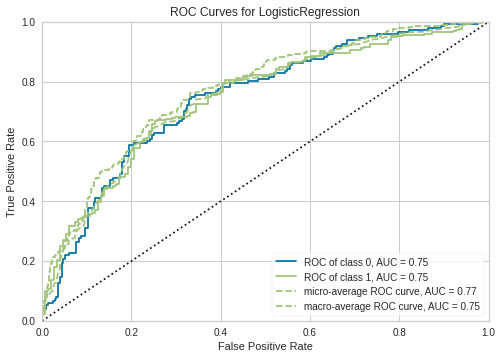

In [30]:
plot_model(lr_tuned)

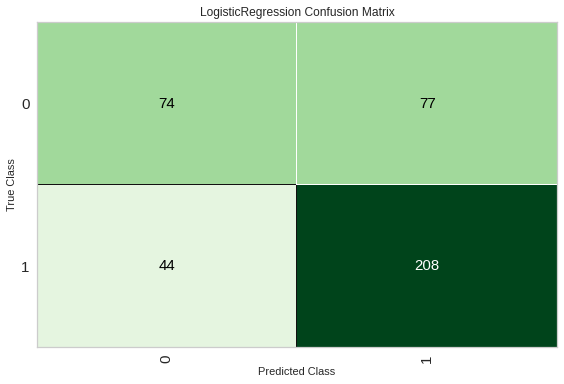

In [31]:
plot_model(lr_tuned, 'confusion_matrix')

## Predict

In [32]:
predict_model(lr_tuned)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.6998,0.7451,0.8254,0.7298,0.7747,0.3299,0.3356


,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs,Label,Score
0,82.0,30.500000,13.0,5.5,10.3,53.099998,0.0,0.0,0.000000,2.1,2.6,79.300003,2.7,5.4,8.1,1.0,0.5,1.8,1.8,1,1,0.9649
1,78.0,13.700000,4.5,2.1,4.1,50.299999,0.0,0.1,40.000000,0.4,0.6,60.900002,0.2,0.7,0.9,0.9,0.2,0.0,0.4,1,1,0.6313
2,58.0,10.600000,4.6,1.7,4.3,38.400002,0.4,1.3,30.100000,0.9,1.3,64.900002,0.6,0.5,1.1,1.0,0.2,0.1,0.9,0,1,0.5345
3,58.0,17.799999,4.1,1.7,3.8,43.700001,0.0,0.0,0.000000,0.7,1.1,65.599998,1.4,1.7,3.1,0.7,0.4,1.5,0.8,1,1,0.7209
4,82.0,38.599998,19.0,6.7,15.7,42.900002,2.3,6.1,36.799999,3.3,3.9,84.400002,0.5,2.6,3.1,6.5,0.9,0.2,3.0,1,1,0.9297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398,81.0,28.900000,13.5,4.9,11.8,41.700001,1.0,2.7,35.799999,2.8,3.3,82.599998,0.3,2.1,2.4,4.4,1.0,0.0,2.9,0,1,0.8240
399,44.0,6.400000,2.4,1.0,1.9,53.700001,0.0,0.0,0.000000,0.4,0.7,50.000000,0.4,1.0,1.4,0.2,0.2,0.4,0.6,1,0,0.6700
400,64.0,12.700000,4.1,1.8,3.3,52.799999,0.0,0.0,19.417675,0.6,1.3,43.500000,1.4,2.4,3.8,0.3,0.2,0.3,0.9,0,1,0.6504
401,57.0,7.700000,2.0,0.7,2.0,36.799999,0.1,0.4,25.000000,0.4,0.7,61.500000,0.4,0.8,1.2,0.4,0.3,0.1,0.4,0,0,0.5967


## Threshold

In [36]:
optimize_threshold(lr_tuned, true_positive = 10000, false_positive = -5000);

Optimized Probability Threshold: 0.3099 | Optimized Cost Function: 1800000


In [37]:
optimize_threshold(lr_tuned, true_positive = 10000, false_positive = -50000);

Optimized Probability Threshold: 0.8483 | Optimized Cost Function: 350000


## Save - Load

In [39]:
save_model(lr_tuned, 'player_classifier')
!ls

Transformation Pipeline and Model Successfully Saved
logs.log  player_classifier.pkl  sample_data


In [40]:
lr_loaded = load_model('player_classifier')

Transformation Pipeline and Model Successfully Loaded


# Continue Learning
* Pandas Expertise
  * Coffee Break Pandas
  * Python for Data Analysis (From the Library Creator)
* Machine Learning
  * Decision Trees
  * Random Forests
* Larger Data
  * PySpark / Databricks
  * Datatable, Dask, Vaex
* Datasets & Notebooks
  * Kaggle Kernels